<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/PJ_Movie_recommendation_System_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load basic library
import re
import numpy as np
import time
import pandas as pd
from tensorflow import random
from sklearn.externals import joblib 
from scipy import stats

# import require packages for plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 
import plotly
from plotly import tools
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import altair as alt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



There are basically three types of recommender systems:-

Demographic Filtering- They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.

Content Based Filtering- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

Collaborative Filtering- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

In [3]:
df1=pd.read_csv('/content/drive/My Drive/Data/tmdb_5000_credits.csv')
df2=pd.read_csv('/content/drive/My Drive/Data/tmdb_5000_movies.csv')

The first dataset contains the following features:-

- movie_id - A unique identifier for each movie.
- cast - The name of lead and supporting actors.
- crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:-

- budget - The budget in which the movie was made.
- genre - The genre of the movie, Action, Comedy ,Thriller etc.
- homepage - A link to the homepage of the movie.
- id - This is infact the movie_id as in the first dataset.
- keywords - The keywords or tags related to the movie.
- original_language - The language in which the movie was made.
- original_title - The title of the movie before translation or adaptation.
- overview - A brief description of the movie.
- popularity - A numeric quantity specifying the movie popularity.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date on which it was released.
- revenue - The worldwide revenue generated by the movie.
- runtime - The running time of the movie in minutes.
- status - "Released" or "Rumored".
- tagline - Movie's tagline.
- title - Title of the movie.
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

Let's join the two dataset on the 'id' column

In [ ]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [7]:
df2.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [5]:
df2.shape

(4803, 23)

# Demographic Filtering

Before getting started with this -

- we need a metric to score or rate movie
- Calculate the score for every movie
- Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes. So, I'll be using IMDB's weighted rating (wr) which is given as :-

where,

- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; And
- C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [9]:
df2.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [6]:
C= df2['vote_average'].mean()
C

6.092171559442011

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [10]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [11]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [12]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1) # x is df each row

In [15]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Hurray! We have made our first(though very basic) recommender. Under the Trending Now tab of these systems we find movies that are very popular and they can just be obtained by sorting the dataset by the popularity column.

Text(0.5, 1.0, 'Popular Movies')

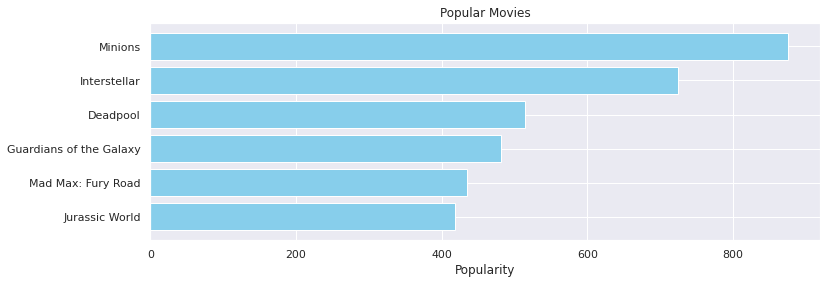

In [16]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. This is when we move on to a more refined system- Content Basesd Filtering.

# Content Based Filtering

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

## Plot description based Recommender

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the overview feature of our dataset. Let's take a look at the data. ..

In [17]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

For any of you who has done even a bit of text processing before knows we need to convert the word vector of each overview. Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term is given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it?

In [18]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

TF-IDF là gì?

TF-IDF (Term Frequency – Inverse Document Frequency) là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu. Một vài biến thể của tf-idf thường được sử dụng trong các hệ thống tìm kiếm như một công cụ chính để đánh giá và sắp xếp văn bản dựa vào truy vấn của người dùng.  Tf-idf cũng được sử dụng để lọc những từ stopwords trong các bài toán như tóm tắt văn bản và phân loại văn bản.

Sau đây, chúng ta sẽ đi chi tiết vào từng thành phần. Và sau đó, chúng ta đi đến công thức tính tf-idf. Cuối cùng là những ví dụ sinh động để các bạn hiểu sâu và kỹ về TF-IDF là gì.

TF là gì?
TF: Term Frequency(Tần suất xuất hiện của từ) là số lần từ xuất hiện trong văn bản. Vì các văn bản có thể có độ dài ngắn khác nhau nên một số từ có thể xuất hiện nhiều lần trong một văn bản dài hơn là một văn bản ngắn. Như vậy, term frequency thường được chia cho độ dài văn bản( tổng số từ trong một văn bản).

IDF là gì?
IDF: Inverse Document Frequency(Nghịch đảo tần suất của văn bản), giúp đánh giá tầm quan trọng của một từ . Khi tính toán TF , tất cả các từ được coi như có độ quan trọng bằng nhau. Nhưng  một số từ như “is”, “of” và “that” thường xuất hiện rất nhiều lần nhưng độ quan trọng là không cao. Như thế chúng ta cần giảm độ quan trọng của những từ này xuống.

In [19]:
#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

In [20]:
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])
print(tfidf_matrix.shape)
tfidf_matrix

(4803, 20978)


<4803x20978 sparse matrix of type '<class 'numpy.float64'>'
	with 125840 stored elements in Compressed Sparse Row format>

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the cosine similarity scores. There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [22]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [24]:
df2.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802],
           dtype='int64', length=4803)

In [23]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

We are now in a good position to define our recommendation function. These are the following steps we'll follow :

- Get the index of the movie given its title.

- Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
- Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
- Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
- Return the titles corresponding to the indices of the top elements.